In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, precision_recall_curve, confusion_matrix,
                             classification_report, average_precision_score)
from sklearn.preprocessing import LabelEncoder
from itertools import cycle


In [3]:
df = pd.read_csv('/content/drive/MyDrive/merged_V2.csv')

In [4]:
import gc# 예시: df가 이미 로드된 DataFrame이며, modify_columns는 '_x' 또는 '_y'가 포함된 열 목록입니다.
modify_columns = [col for col in df.columns if '_x' in col or '_y' in col]

# SMA와 EMA 함수 정의
def sma(series, window_size):
    return series.rolling(window=window_size, min_periods=1).mean()

def ema(series, window_size):
    return series.ewm(span=window_size, adjust=False).mean()

window_size = 10
alpha = 0.4  # 하이브리드 계산 비율

# 대상 열들의 데이터 타입을 float32로 다운캐스팅 (메모리 절약)
for col in modify_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce', downcast='float')

# 각 열에 대해 SMA, EMA, Hybrid 계산 (중간 변수는 바로 삭제)
for col in modify_columns:
    # SMA와 EMA를 계산 (결과를 float32로 변환)
    sma_val = sma(df[col], window_size).astype(np.float32)
    ema_val = ema(df[col], window_size).astype(np.float32)

    # Hybrid 값 계산: alpha * EMA + (1 - alpha) * SMA
    hybrid_val = alpha * ema_val + (1 - alpha) * sma_val

    # 결과를 새로운 열로 할당
    df[f"{col}_Hybrid"] = hybrid_val

    # 중간 변수 삭제 및 메모리 정리
    del sma_val, ema_val, hybrid_val
    gc.collect()

# 결과 예시: 상위 10개 열의 첫 5행 출력
print(df[[col for col in df.columns if 'Hybrid' in col]].head(5))

<ipython-input-4-d69f52b9c76d>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_Hybrid"] = hybrid_val
<ipython-input-4-d69f52b9c76d>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_Hybrid"] = hybrid_val
<ipython-input-4-d69f52b9c76d>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.co

   Nose_x_Hybrid  Nose_y_Hybrid  LEye_x_Hybrid  LEye_y_Hybrid  REye_x_Hybrid  \
0    1368.317139     245.318161    1375.947510     242.774719    1368.317139   
1    1367.967676     245.556226    1375.636328     242.039227    1367.967676   
2    1367.396606     246.379282    1375.064771     242.456949    1367.396606   
3    1366.877783     246.662259    1374.560645     242.479083    1366.877783   
4    1365.957910     246.807062    1373.648706     242.441040    1366.454175   

   REye_y_Hybrid  LEar_x_Hybrid  LEar_y_Hybrid  REar_x_Hybrid  REar_y_Hybrid  \
0     240.231262    1388.664673     245.318161    1386.121338     245.318161   
1     240.443787    1388.417432     245.556226    1385.861279     245.556226   
2     241.267200    1387.844897     245.681915    1385.288892     245.681915   
3     241.540338    1387.365527     246.126553    1384.230176     245.552191   
4     241.183694    1386.466602     246.375720    1383.440063     245.912830   

   ...  RBigToe_x_Hybrid  RBigToe_y_Hy

In [5]:
df = df.drop(['image_filename', 'Nose_x', 'Nose_y', 'LEye_x', 'LEye_y', 'REye_x', 'REye_y', 'LEar_x', 'LEar_y', 'REar_x', 'REar_y', 'LShoulder_x', 'LShoulder_y', 'RShoulder_x', 'RShoulder_y', 'LElbow_x', 'LElbow_y', 'RElbow_x', 'RElbow_y', 'LWrist_x', 'LWrist_y', 'RWrist_x', 'RWrist_y', 'LHip_x', 'LHip_y', 'RHip_x', 'RHip_y', 'LKnee_x', 'LKnee_y', 'RKnee_x', 'RKnee_y', 'LAnkle_x', 'LAnkle_y', 'RAnkle_x', 'RAnkle_y', 'Head_x', 'Head_y', 'Neck_x', 'Neck_y', 'Hip_x', 'Hip_y', 'LBigToe_x', 'LBigToe_y', 'RBigToe_x', 'RBigToe_y', 'LSmallToe_x', 'LSmallToe_y', 'RSmallToe_x', 'RSmallToe_y', 'LHeel_x', 'LHeel_y', 'RHeel_x', 'RHeel_y', 'gender', 'level','path'], axis=1)

In [6]:
encoder = LabelEncoder()
encoder.fit(df['label'])

df["label"] = encoder.transform(df['label'])
df
# 0 = jump, 1 = spin, 2 = step

,label,Nose_x_Hybrid,Nose_y_Hybrid,LEye_x_Hybrid,LEye_y_Hybrid,REye_x_Hybrid,REye_y_Hybrid,LEar_x_Hybrid,LEar_y_Hybrid,REar_x_Hybrid,...,RBigToe_x_Hybrid,RBigToe_y_Hybrid,LSmallToe_x_Hybrid,LSmallToe_y_Hybrid,RSmallToe_x_Hybrid,RSmallToe_y_Hybrid,LHeel_x_Hybrid,LHeel_y_Hybrid,RHeel_x_Hybrid,RHeel_y_Hybrid
0,0,1368.317139,245.318161,1375.947510,242.774719,1368.317139,240.231262,1388.664673,245.318161,1386.121338,...,1355.599976,466.598053,1360.686768,466.598053,1355.599976,464.054596,1383.577881,456.424255,1386.121338,456.424255
1,0,1367.967676,245.556226,1375.636328,242.039227,1367.967676,240.443787,1388.417432,245.556226,1385.861279,...,1355.186572,466.025378,1360.299048,466.986163,1355.186572,463.469141,1384.265820,456.761285,1385.861279,456.761285
2,0,1367.396606,246.379282,1375.064771,242.456949,1367.396606,241.267200,1387.844897,245.681915,1385.288892,...,1355.313794,466.022192,1359.728442,466.691125,1355.313794,463.466150,1383.401782,457.164319,1386.683691,456.466949
3,0,1366.877783,246.662259,1374.560645,242.479083,1366.877783,241.540338,1387.365527,246.126553,1384.230176,...,1355.183081,466.221564,1359.769238,466.733728,1355.183081,463.660596,1382.755713,457.599915,1387.024707,456.489856
4,0,1365.957910,246.807062,1373.648706,242.441040,1366.454175,241.183694,1386.466602,246.375720,1383.440063,...,1355.026733,466.233124,1359.722510,466.645117,1355.026733,463.669556,1383.736279,457.781274,1387.180078,456.390839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196118,2,585.031738,484.142755,594.090820,473.744873,578.638062,474.733527,616.823914,472.022913,575.282751,...,603.309851,838.039856,635.471045,841.485254,594.438525,831.847766,653.024878,809.914111,621.924414,808.549854
10196119,2,579.420007,487.238281,589.045703,476.913342,573.361340,477.816235,611.570459,474.986072,569.915381,...,597.124512,843.756177,629.614563,848.094043,588.227075,837.328479,647.587024,815.887744,616.630615,813.482556
10196120,2,573.913245,490.298022,584.046973,480.274530,567.601501,481.107300,606.594763,478.179694,564.081726,...,591.101709,849.122656,623.857788,854.613159,582.183740,842.835193,642.411768,822.085815,611.380505,818.738635
10196121,2,568.722803,494.074084,578.735974,483.786365,562.214062,485.128497,601.844116,481.316479,558.639001,...,584.861243,854.355859,617.794458,861.432678,575.936572,848.188159,636.844788,828.683105,606.030676,824.483704


In [8]:
import numpy as np

def add_adversarial_noise_optimized(df, epsilon=2.0):
    # 필요한 컬럼 리스트
    hybrid_columns = [col for col in df.columns if col.endswith("_Hybrid") and ('_x' in col or '_y' in col)]
    # 원본 복사는 최소한으로 (필요한 부분만 복사)
    df_adv = df.copy(deep=False)  # 얕은 복사: 메모리 사용량이 줄어듦 (단, 내부 데이터가 수정되면 원본에도 영향이 있을 수 있음)

    # 모든 SMA 컬럼에 대해 한 번에 noise 행렬 생성 후 적용
    noise = np.random.uniform(-epsilon, epsilon, size=(df_adv.shape[0], len(hybrid_columns)))
    df_adv.loc[:, hybrid_columns] = df_adv.loc[:, hybrid_columns] + noise
    return df_adv

# 최적화된 함수 사용
df_adv = add_adversarial_noise_optimized(df, epsilon=2.0)

In [10]:
X = df.drop(['label'], axis=1)
Y = df['label']

print(X.shape)
print(Y.shape)

(10196123, 52)
(10196123,)


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y, test_size=0.2, random_state=42, stratify = Y
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(6525518, 52)
(2039225, 52)
(6525518,)
(2039225,)
(1631380, 52)
(1631380,)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
import numpy as np

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=False)

X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y.values, dtype=torch.long)

print(f"Total dataset size: {X_tensor.shape}")
print(f"Using {n_splits}-fold cross-validation")

Total dataset size: torch.Size([10196123, 52])
Using 5-fold cross-validation


In [13]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [14]:
def dataloader(X_train, Y_train, X_val, Y_val, batch_size=64):
    train_dataset = CustomDataset(X_train, Y_train)
    val_dataset = CustomDataset(X_val, Y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(1))  # (batch, seq_len=1, features)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력 사용
        return out


In [16]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_classes, num_heads=4, hidden_dim=128, num_layers=2):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.transformer_encoder(x.unsqueeze(1))  # (batch, seq_len=1, features)
        x = self.fc(x[:, -1, :])  # 마지막 타임스텝의 출력 사용
        return x


In [17]:
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=1e-4, device="cuda"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct, total = 0, 0

        # Training loop
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y_batch).sum().item()
            total += Y_batch.size(0)

        train_acc = correct / total

        # Validation loop
        model.eval()  # 평가 모드 전환
        val_loss = 0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == Y_batch).sum().item()
                total_val += Y_batch.size(0)

        val_acc = correct_val / total_val

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

    return model


def get_predictions(model, test_loader, device="cuda"):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)  # 확률로 변환
            all_probs.append(probs.cpu().numpy())
    return np.concatenate(all_probs, axis=0)




In [18]:
# Test Set을 NumPy 배열로 변환 후 PyTorch Tensor로 변환
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long)

# Test Dataset & DataLoader 생성
test_dataset = CustomDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Test set size: {len(test_dataset)} samples")

Test set size: 2039225 samples


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(np.unique(Y))  # 클래스 개수
input_size = X.shape[1]  # 입력 특성 개수

# 테스트셋 샘플 수와 클래스 수를 이용해 예측 확률 누적 배열 생성
ensemble_lstm_probs = np.zeros((len(test_dataset), num_classes))
ensemble_transformer_probs = np.zeros((len(test_dataset), num_classes))


# K-Fold 학습 및 각 fold 모델의 예측값 누적
for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor, Y_tensor)):
    print(f" Fold {fold+1}/{n_splits}")

    # 데이터 분할
    X_train_fold, Y_train_fold = X_tensor[train_idx], Y_tensor[train_idx]
    X_val_fold, Y_val_fold = X_tensor[val_idx], Y_tensor[val_idx]

    train_loader, val_loader = dataloader(X_train_fold, Y_train_fold, X_val_fold, Y_val_fold, batch_size=32)

    # LSTM 모델 학습
    lstm_model = LSTMModel(input_size=input_size, hidden_size=64, num_layers=2, num_classes=num_classes)
    print(" Training LSTM Model")
    trained_lstm = train_model(lstm_model, train_loader, val_loader, epochs=7, device=device)

    # Transformer 모델 학습
    transformer_model = TransformerModel(input_size=input_size, num_classes=num_classes, num_heads=4, hidden_dim=128, num_layers=2)
    print(" Training Transformer Model")
    trained_transformer = train_model(transformer_model, train_loader, val_loader, epochs=7, device=device)

    # 각 fold의 모델로 테스트셋 예측 (확률)
    lstm_fold_probs = get_predictions(trained_lstm, test_loader, device=device)
    transformer_fold_probs = get_predictions(trained_transformer, test_loader, device=device)

    # 각 fold의 예측값을 누적 (앙상블을 위해)
    ensemble_lstm_probs += lstm_fold_probs
    ensemble_transformer_probs += transformer_fold_probs



 Fold 1/5
 Training LSTM Model
Epoch 1/7, Train Loss: 1.0240, Train Acc: 0.4798, Val Loss: 1.0315, Val Acc: 0.5033
Epoch 2/7, Train Loss: 1.0119, Train Acc: 0.4913, Val Loss: 1.0096, Val Acc: 0.5014
Epoch 3/7, Train Loss: 1.0050, Train Acc: 0.4973, Val Loss: 1.0364, Val Acc: 0.4865
Epoch 4/7, Train Loss: 1.0102, Train Acc: 0.4958, Val Loss: 1.0120, Val Acc: 0.5127
Epoch 5/7, Train Loss: 1.0091, Train Acc: 0.4974, Val Loss: 1.0274, Val Acc: 0.4984
Epoch 6/7, Train Loss: 1.0084, Train Acc: 0.4975, Val Loss: 1.0223, Val Acc: 0.5039
Epoch 7/7, Train Loss: 1.0074, Train Acc: 0.4994, Val Loss: 1.0343, Val Acc: 0.4921
 Training Transformer Model


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/7, Train Loss: 0.8682, Train Acc: 0.5950, Val Loss: 0.9664, Val Acc: 0.5430
Epoch 2/7, Train Loss: 0.7545, Train Acc: 0.6603, Val Loss: 0.9305, Val Acc: 0.5561
Epoch 3/7, Train Loss: 0.6998, Train Acc: 0.6891, Val Loss: 0.9011, Val Acc: 0.5873
Epoch 4/7, Train Loss: 0.6779, Train Acc: 0.7000, Val Loss: 0.9324, Val Acc: 0.5831
Epoch 5/7, Train Loss: 0.6585, Train Acc: 0.7100, Val Loss: 0.9329, Val Acc: 0.5818
Epoch 6/7, Train Loss: 0.6361, Train Acc: 0.7214, Val Loss: 0.8988, Val Acc: 0.5850
Epoch 7/7, Train Loss: 0.6199, Train Acc: 0.7300, Val Loss: 0.8738, Val Acc: 0.5972
 Fold 2/5
 Training LSTM Model
Epoch 1/7, Train Loss: 1.0186, Train Acc: 0.4745, Val Loss: 1.0315, Val Acc: 0.4834
Epoch 2/7, Train Loss: 1.0112, Train Acc: 0.4809, Val Loss: 1.0381, Val Acc: 0.4936
Epoch 3/7, Train Loss: 1.0056, Train Acc: 0.4868, Val Loss: 1.0306, Val Acc: 0.4559
Epoch 4/7, Train Loss: 1.0009, Train Acc: 0.4906, Val Loss: 1.0203, Val Acc: 0.4956
Epoch 5/7, Train Loss: 0.9976, Train Acc: 0.4

In [20]:
# 각 모델의 예측 확률을 평균 내어 최종 예측값 도출
ensemble_lstm_probs /= n_splits
ensemble_transformer_probs /= n_splits

# 예측 확률에서 최종 클래스 라벨 도출 (argmax)
ensemble_lstm_preds = np.argmax(ensemble_lstm_probs, axis=1)
ensemble_transformer_preds = np.argmax(ensemble_transformer_probs, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print("=== LSTM Ensemble Evaluation ===")
print("Classification Report:")
print(classification_report(Y_test.values, ensemble_lstm_preds))
print("Confusion Matrix:")
print(confusion_matrix(Y_test.values, ensemble_lstm_preds))

print("\n=== Transformer Ensemble Evaluation ===")
print("Classification Report:")
print(classification_report(Y_test.values, ensemble_transformer_preds))
print("Confusion Matrix:")
print(confusion_matrix(Y_test.values, ensemble_transformer_preds))


=== LSTM Ensemble Evaluation ===
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.70      0.63    921106
           1       0.44      0.61      0.51    656960
           2       0.81      0.00      0.00    461159

    accuracy                           0.51   2039225
   macro avg       0.61      0.44      0.38   2039225
weighted avg       0.58      0.51      0.45   2039225

Confusion Matrix:
[[647354 273748      4]
 [256680 400274      6]
 [215116 246000     43]]

=== Transformer Ensemble Evaluation ===
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80    921106
           1       0.76      0.71      0.73    656960
           2       0.73      0.63      0.67    461159

    accuracy                           0.75   2039225
   macro avg       0.75      0.73      0.74   2039225
weighted avg       0.75      0.75      0.75   2039225

Confusion Matrix:
[[785085 

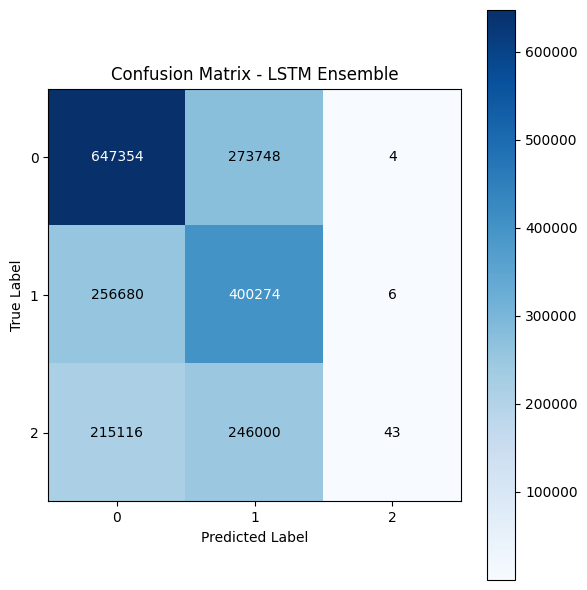

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 혼동 행렬 계산
cm = confusion_matrix(Y_test.values, ensemble_lstm_preds)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - LSTM Ensemble")
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# 셀 값 표시
fmt = 'd'
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# 다중 클래스의 경우 True 라벨을 바이너리화
classes = np.unique(Y_test.values)
n_classes = len(classes)
Y_test_bin = label_binarize(Y_test.values, classes=classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], ensemble_lstm_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(Y_test_bin[:, i], ensemble_lstm_probs[:, i])
    avg_precision[i] = average_precision_score(Y_test_bin[:, i], ensemble_lstm_probs[:, i])


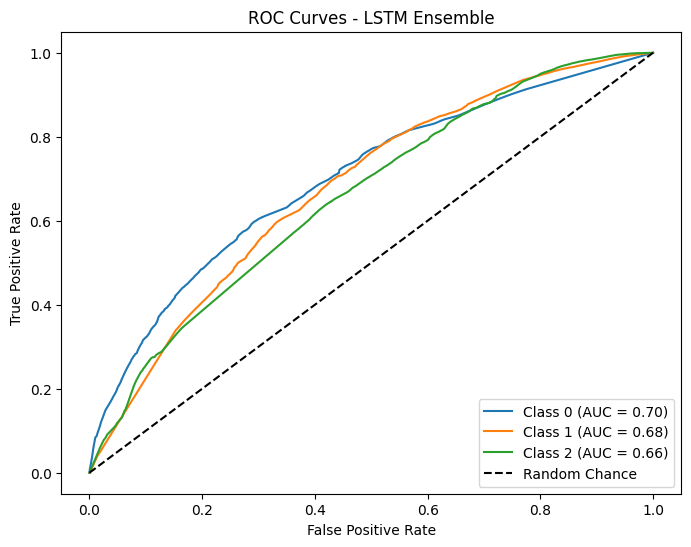

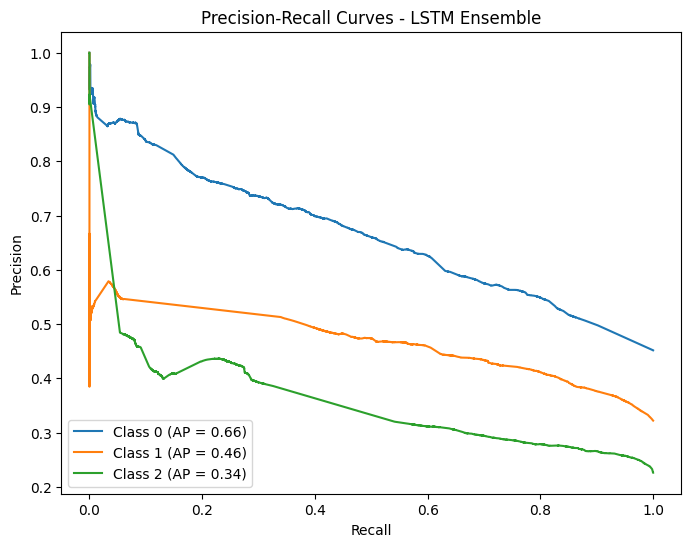

In [23]:
# ROC Curve 그리기
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - LSTM Ensemble")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve 그리기
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f"Class {i} (AP = {avg_precision[i]:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves - LSTM Ensemble")
plt.legend(loc="lower left")
plt.show()

In [24]:
# Accuracy 및 Error Rate 계산
accuracy = np.sum(Y_test.values == ensemble_lstm_preds) / len(Y_test.values)
error_rate = 1 - accuracy

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Error Rate: {error_rate:.4f}")


Test Accuracy: 0.5138
Error Rate: 0.4862


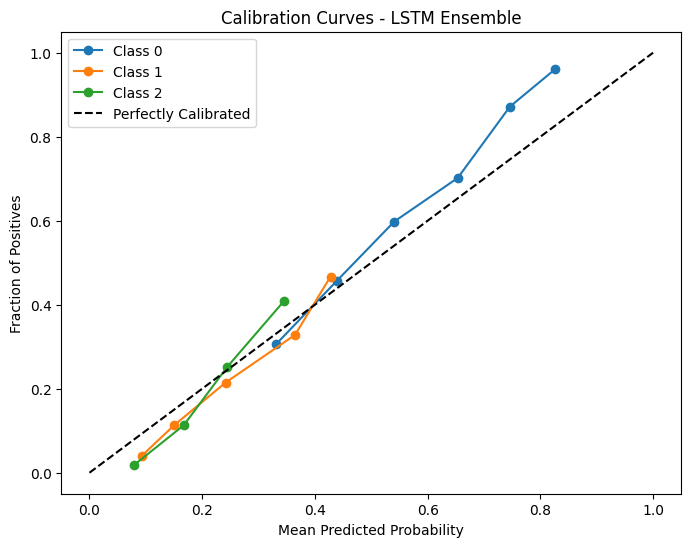

In [25]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fraction_of_positives, mean_predicted_value = calibration_curve(Y_test_bin[:, i], ensemble_lstm_probs[:, i], n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f"Class {i}")
plt.plot([0, 1], [0, 1], 'k--', label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves - LSTM Ensemble")
plt.legend(loc="best")
plt.show()


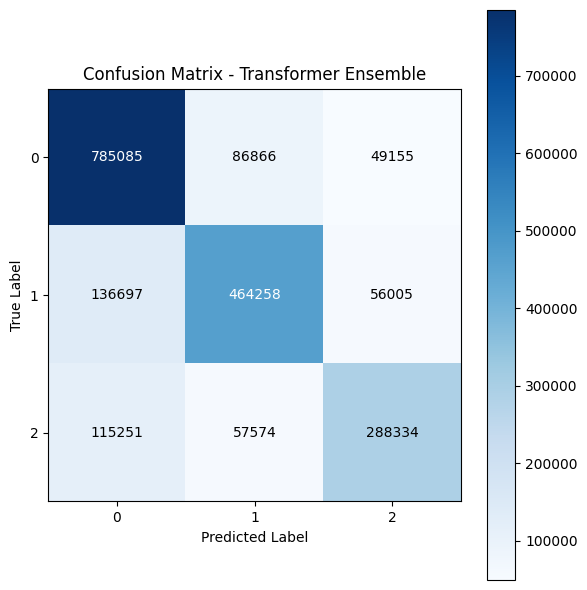

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 혼동 행렬 계산
cm_trans = confusion_matrix(Y_test.values, ensemble_transformer_preds)

plt.figure(figsize=(6, 6))
plt.imshow(cm_trans, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Transformer Ensemble")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# 셀 값 표시
fmt = 'd'
thresh = cm_trans.max() / 2.0
for i in range(cm_trans.shape[0]):
    for j in range(cm_trans.shape[1]):
        plt.text(j, i, format(cm_trans[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm_trans[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


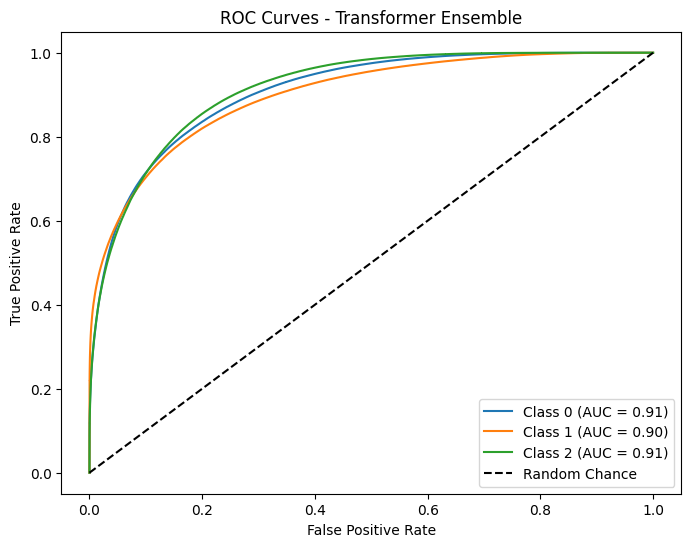

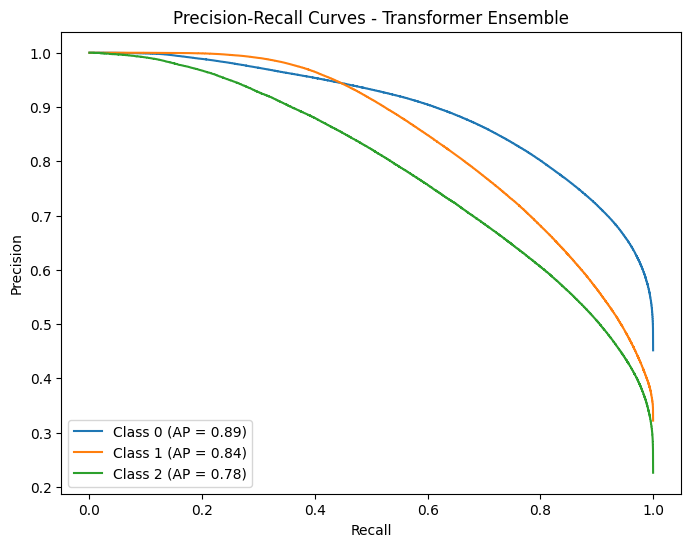

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# 다중 클래스의 경우 True 라벨을 바이너리화
classes = np.unique(Y_test.values)
n_classes = len(classes)
Y_test_bin = label_binarize(Y_test.values, classes=classes)

fpr_trans = dict()
tpr_trans = dict()
roc_auc_trans = dict()
precision_trans = dict()
recall_trans = dict()
avg_precision_trans = dict()

for i in range(n_classes):
    fpr_trans[i], tpr_trans[i], _ = roc_curve(Y_test_bin[:, i], ensemble_transformer_probs[:, i])
    roc_auc_trans[i] = auc(fpr_trans[i], tpr_trans[i])
    precision_trans[i], recall_trans[i], _ = precision_recall_curve(Y_test_bin[:, i], ensemble_transformer_probs[:, i])
    avg_precision_trans[i] = average_precision_score(Y_test_bin[:, i], ensemble_transformer_probs[:, i])

# ROC Curve 그리기
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr_trans[i], tpr_trans[i], label=f"Class {i} (AUC = {roc_auc_trans[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Transformer Ensemble")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve 그리기
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall_trans[i], precision_trans[i], label=f"Class {i} (AP = {avg_precision_trans[i]:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves - Transformer Ensemble")
plt.legend(loc="lower left")
plt.show()


In [28]:
# Accuracy 및 Error Rate 계산
accuracy_trans = np.sum(Y_test.values == ensemble_transformer_preds) / len(Y_test.values)
error_rate_trans = 1 - accuracy_trans

print(f"Transformer Test Accuracy: {accuracy_trans:.4f}")
print(f"Transformer Error Rate: {error_rate_trans:.4f}")


Transformer Test Accuracy: 0.7540
Transformer Error Rate: 0.2460


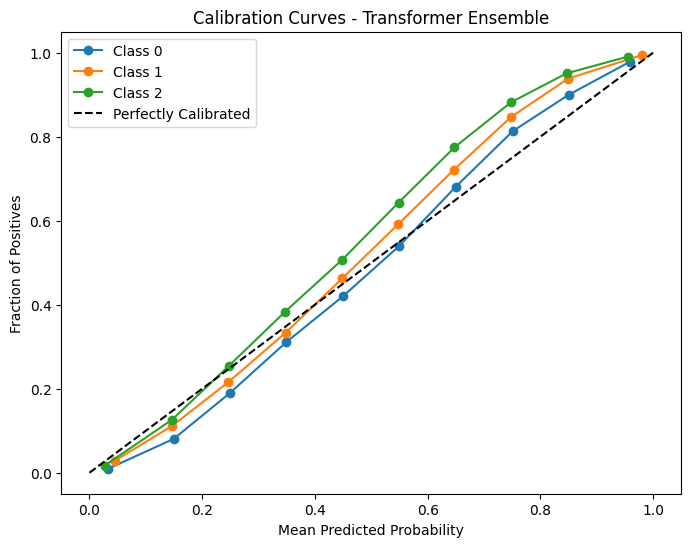

In [29]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fraction_of_positives, mean_predicted_value = calibration_curve(Y_test_bin[:, i], ensemble_transformer_probs[:, i], n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f"Class {i}")
plt.plot([0, 1], [0, 1], 'k--', label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves - Transformer Ensemble")
plt.legend(loc="best")
plt.show()
